# ModIty -  <font color='red'>Mod</font>el for the  <font color='red'>I</font>dentification of <font color='red'>Ty</font>peregions

In [1]:
import pandas as pd
import numpy as np
import modity as mod

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Klasse instanziieren

In [3]:
bachelor = mod.Project(input_folder='Input')

----------------------------------------------------------
Folder "Input" already exists in current directory.
----------------------------------------------------------
Folder "graphics" already exists in current directory.
----------------------------------------------------------
Folder "output" already exists in current directory.
----------------------------------------------------------
Path of Input folder saved in instance 'input_path'.


,NUTS3,AGS,PLZ,transfer
0,NaN,AGS_AIRE.csv,NaN,Transfertabelle.csv


### Datensatz auswählen und bearbeiten

In [4]:
file = pd.read_csv(bachelor.input_path +'/AGS_AIRE.csv', sep=';', decimal=',', thousands='.',index_col=0)
file.drop(columns=['GEN','BEZ'], inplace=True)

### an Klasse übergeben

In [5]:
bachelor.import_data_file(file, 'AGS')

file imported
NUTS3 assigned data saved to df_data.
Memory was initiated!


### Normalverteilung überprüfen

In [6]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
def shapiro_test(data):
    shapiro_p_values = []
    for i in range(data.shape[1]):
        shapiro_p_values.append(shapiro(data[:,i])[1])

    plt.bar(range(data.shape[1]),shapiro_p_values)
    plt.locator_params(axis='x', nbins=data.shape[1]*2)
    plt.grid()
    plt.title('Shapiro - Test')
    plt.show()

    #shapiro_p_values>np.mean(shapiro_p_values)
    print('Anzahl der Normalverteilten')
    print(sum(np.ravel(shapiro_p_values)>0.5))
    return shapiro_p_values

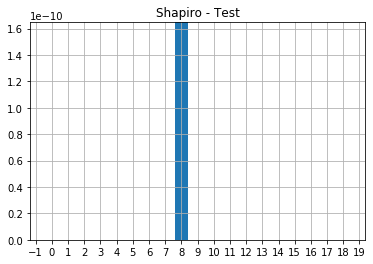

Anzahl der Normalverteilten
0


In [7]:
p_values_shapiro = shapiro_test(bachelor.df_data.values)

### Korrelationsanalyse des ganzen Datensatzes
- keine Normalverteilung, deshalb Methode nach Kendall

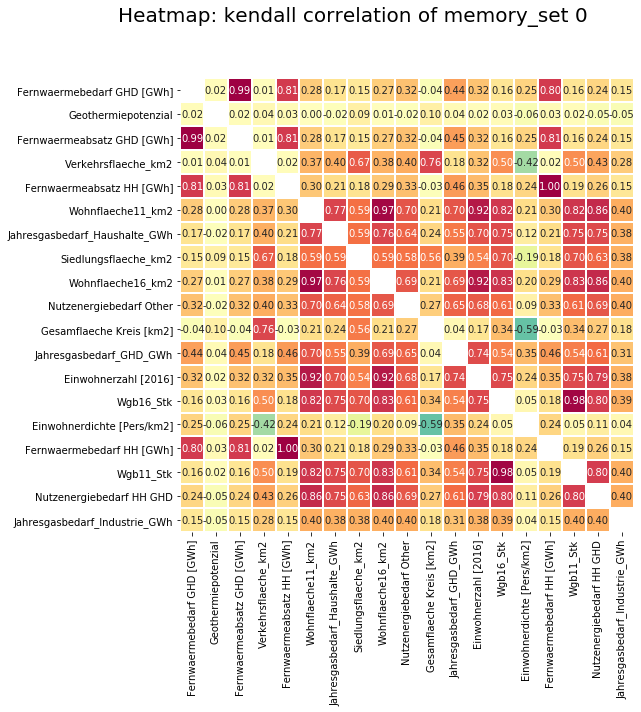

In [8]:
bachelor.correlation(method='kendall',heatmap=True, memory_set=0, save=False)

- sehr viele Features
- hohe Abhängigkeiten untereinander
- Datensatz mit geringer korrelation wird identifizert

### Variante 1

In [9]:
bachelor.select_features(reject=[0,1,3,4,5,6,8,10,13,14,15,16,17], memory_set=0)

memory_set=0 is base!
manipulated and saved as memory_set=1


/Users/Julian/opt/miniconda3/envs/mein_cluster/lib/python3.7/site-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [ ]:
bachelor.correlation(method='kendall', heatmap=True,threshold=0.6, memory_set=1, save=False)

- geringe Korrelationswerte < 0.6

### Ausreißer identifizieren und entfernen

In [ ]:
bachelor.outliers(memory_set=1,save=False)

- der Grenzwert wurde auf 15 gesetzt
- hauptsächlich Großstädte wurde als Ausreißer identifiziert
- Ludwigshafen und Wittenberg haben starken Industrieeinfluss
- das Entfernen der Ausreißer wurde bestätigt

### Vergleich des Datensatzes vor und nach der Ausreiserentfernung

In [ ]:
bachelor.violinplots(memory_set=1, scaler='standard', save=False)

In [ ]:
bachelor.violinplots(memory_set=2, scaler='standard', save=False)

In [ ]:
bachelor.show_features()

In [ ]:
bachelor.show_samples()

### optimale Anzahl der Cluster bestimmen

In [ ]:
bachelor.optimal_k(memory_set=2, kmax=20, scaler='standard', plot=True)

- gute und weitgehend eindeutige Ergebniss
- CH, DB und Sil schränken den Bereich auf 6 und 7 ein
- SSR ist uneindeutig

### loopen um robuste Ergebnisses zu prüfen
- k = 6 testen
- k = 7 testen

In [ ]:
bachelor.loop_clustering(memory_set=2, k_cluster=7, max_loops=30)

- k=7 liefert robustere Zuweisungen

### Clustergrößen vergleichen

In [ ]:
size_var1_m2 = bachelor.cluster_sizes(memory_set=2, k_cluster=7)

- Cluster mit nur einem Sample ist auffällig

### Singleton identifizieren

In [ ]:
singleton = (2,1)
labels_var1_m2 = bachelor.get_labels(memory_set=2, k_cluster=7, loop=singleton[1])
single_var1_m2 = labels_var1_m2[~labels_var1_m2.ne(singleton[0])]
single_var1_m2 = bachelor.df_transfer.Name[single_var1_m2.index]
# export to .tex
#single_var1_m2.to_latex('./graphics/single_var1.tex')
single_var1_m2

### sample entfernen

In [ ]:
bachelor.select_samples(memory_set=2, reject=single_var1_m2.index)

## erneut optimieren

In [ ]:
bachelor.optimal_k(memory_set=3, kmax=20, scaler='standard', plot=True)

- CH, DB und Sil empfehlen k=6

### loopen um robuste Ergebnisses zu prüfen
- k = 6 testen

In [ ]:
bachelor.loop_clustering(memory_set=3, k_cluster=6, max_loops=30)

### Clustergrößen vergleichen

In [ ]:
size_var1_m3 = bachelor.cluster_sizes(memory_set=3, k_cluster=6)

- deutlich weniger Varianz ei der Zuordnung
- Nur wenige Clusterspringer zu erkennen
- dies könnten im nächsten Schritt identifiziert und versuchsweiße entfernt werden

### Clusterspringer identifizieren

In [ ]:
borderliner_var1_m3 = bachelor.borderliner(memory_set=3, k_cluster=6)

### testweise entfernen der springer

In [ ]:
bachelor.select_samples(memory_set=3, reject=borderliner_var1_m3.index)

### wiederholt optimieren

In [ ]:
bachelor.optimal_k(memory_set=4, kmax=20, scaler='standard', plot=True)

- clusteranzahl bleibt bei k=6

### loopen mit k=6

In [ ]:
bachelor.loop_clustering(memory_set=4, k_cluster=6, max_loops=30)

- eindeutiges Ergebnis

### Clustregrößen

In [ ]:
size_var1_m4a = bachelor.cluster_sizes(memory_set=4, k_cluster=6)

# Silhouetten plot

In [ ]:
bachelor.plot_silhouettes(memory_set=4, k_cluster=6, loop=0, save=False)

In [ ]:
bachelor.plot_cluster(memory_set=4, k_cluster=6, loop=0, save=False)

### Typregionen identifizieren
- Clustergrößen anhängen

In [ ]:
typregions= bachelor.ident_typregions(memory_set=4, k_cluster=6, loop=0)
# export to .tex
#typregions.join(size[0].rename('Clustergröße')).to_latex('./graphics/typregions_var1.tex')
typregions.join(size_var1_m4a[0].rename('Clustergröße'))

### Typregionen visualisieren

In [ ]:
bachelor.plot_typregions(memory_set=4, k_cluster=6, loop=0, save=False)

### Datensatz extrahieren

In [ ]:
df_clustering = bachelor.get_clustering(memory_set=4, k_cluster=6, loop=0)
df_clustering.iloc[:,:-2] = bachelor.normalization(df_clustering.iloc[:,:-2], scaler='minmax')
df_clustering.Cluster = df_clustering.Cluster.astype(int)

## Zusätzliche Plots zum Vergleichen der Ergebnisse

In [ ]:
# colormap registrieren
import matplotlib.cm as cm
cmap = cm.get_cmap("Spectral_r")
cmd = bachelor.cmap_discretize(cmap, N=7)
cm.register_cmap("var1_r", cmd)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# boxplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,20))
for n, feature in enumerate(df_clustering.columns[:-2]):
    plt.subplot(2,3, n+1 )
    sns.swarmplot(x ='Cluster',y=feature, data= df_clustering, color="black", edgecolor="gray")
    sns.boxplot(x ='Cluster',y=feature, palette='var1_r', data= df_clustering)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.title(feature, fontsize=15)
plt.show()
#fig.savefig('./graphics/boxplots_feature_var1.pdf',bbox_inches='tight')

### Vergleich der unterschiedlichen Speichersätze

In [ ]:
bachelor.plot_k_scores(memory_set=[2,3,4], save=True)

### Medianwerte der Endergebnisse berechnen

In [ ]:
clustering = bachelor.get_clustering(memory_set=4, k_cluster=6, loop=2)
clustering.Cluster = clustering.Cluster.astype(int)
clustering
output = clustering.groupby('Cluster').median().join(size_var1_m3[0].rename('Clustergröße'))
#output.iloc[:,[6,0,1,2,3,4,5]].T.to_latex('./graphics/median_var1.tex')
output.iloc[:,[6,0,1,2,3,4,5]].T

# Ende